# Theoretical Efficiency of Read Until Enrichment

The "Read Until" feature of the Oxford Nanopore sequencing technology means a program can see the data coming in at each pore and, dependend on that data, reject the molecule inside a certain pore.

The actual performance of such a method depends on a lot of factors:

* ratio of desireable over undesireable molecules in the sample
* accuracy of detection
* length of event data necessary for the decision
* latency of event data reaching the controlling program
* delay between decision and ejecting the molecule
* time until the pore can accept a new molecule
* length of DNA strands in the sample

In this notebook I boiled it down to three parameters:

* `ham_frequency` is the frequency of desired molecules
* `ham_duration` is the scale by which the desired molecules are read "longer"
* `accuracy` is the accuracy of the classification

The analogy to spam detection is chosen because "ham/spam" makes for catchier variable names. This computation considers time and "amount of data" as equivalent. In reality, event speeds vary a lot, but in the long run, duration of reads and length of the strands correlate very strongly.

The result of the computation is the ratio of desired time/data over undesired time/data, which is hopefully higher than the original `ham_frequency`.

In [138]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [139]:
def sim_ru(ham_frequency, ham_duration, accuracy):
    # Monte-Carlo Style
    n = 1000000
    ham = np.random.random(size=n)<ham_frequency
    durations = np.ones(n)
    accurate = np.random.random(size=n)<accuracy
    durations[ham & accurate] = ham_duration
    durations[~ham & ~accurate] = ham_duration
    return (np.sum(durations[ham]) / np.sum(durations))


def sim_ru2(ham_frequency, ham_duration, accuracy):
    # exact calculation
    long = ((ham_frequency* accuracy) + (1-ham_frequency)*(1-accuracy)) * ham_duration
    short = ((ham_frequency* (1-accuracy)) + (1-ham_frequency)*(accuracy)) * 1.0
    ham = (ham_frequency* accuracy)*ham_duration + (ham_frequency* (1-accuracy))*1
    return ham / (long+short)

In [140]:
def make_plot(ham_frequency):
    f, ax = plt.subplots()
    f.set_figwidth(14)
    f.set_figheight(6)
    ax.set_ylim(0,1)
    x = np.arange(0.5, 1.0,0.001)
    y = np.zeros(len(x))
    handles = []
    for j in reversed([2.5,5,10,20,40]):
        for i in range(len(x)):
            y[i] = sim_ru2(ham_frequency, j, x[i])
        handles.append(ax.plot(x,y, label = "%.1f" % j))
    ax.grid()
    f.suptitle("Ratio of desired data over total data for different values of \"desired length\"/\"rejected length\"  ")
    ax.legend(loc=0);
    ax.xaxis.set_label_text("Detection Accuracy");
    ax.yaxis.set_label_text("Desired Output /  Total Output");

## 50% ham in sample

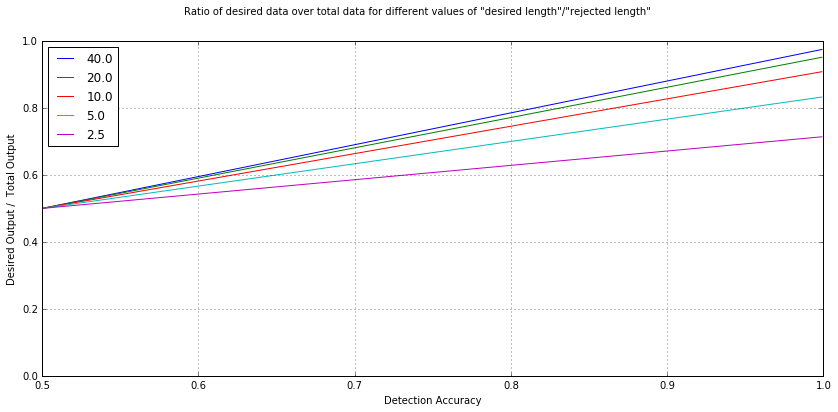

In [141]:
make_plot(0.5)

## 10% ham in sample

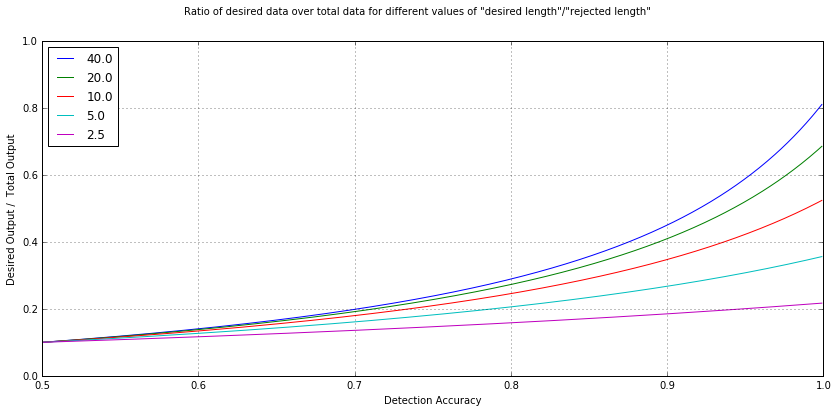

In [142]:
make_plot(0.1)

## 1% ham in sample

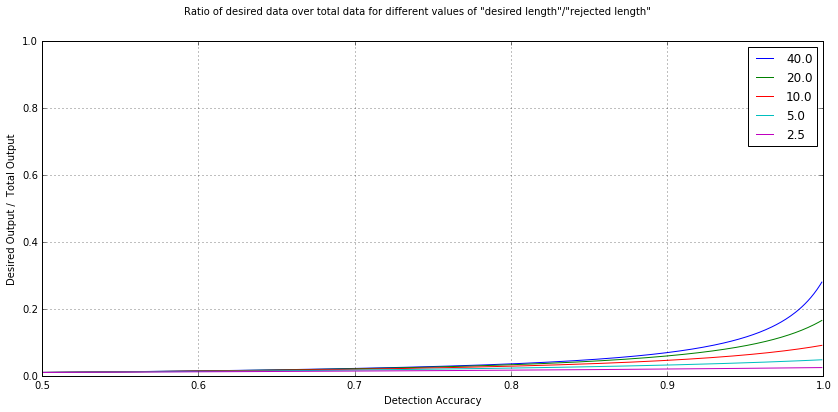

In [147]:
make_plot(0.01)

## Conclusions

I hope this illustrates how to think about and design Read Until workflows.

In practical applications there will be tradeoffs between accuracy and the `ham_duration`: The more time the molecule has to spend inside the pore before ejection the higher the accuracy of the decision and the lower the ratio of the ham/spam duration.

It's also obvious that Read Until strongly favors long reads.